In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kaggle_secrets import UserSecretsClient

In [2]:
# Import wandb
import wandb
from wandb.integration.keras import WandbCallback

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Initialize W&B with Kaggle secrets
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_KEY")
wandb.login(key=secret_value_0)

# Initialize wandb
run = wandb.init(project="Signature_Verification02", name="Test02")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: e20055 (e20055-university-of-peradeniya). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
wandb.init(project="signature_verification02")

# Define the size of the input images
size = 128

# Define the Embedding Model (Feature Extractor)
def build_embedding_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(4, 4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(4, 4),

        tf.keras.layers.Flatten(),
    ], name='embedding_model')
    return model

# Define Inputs for Siamese Network
input_a = tf.keras.layers.Input(shape=(size, size, 1), name='input1')
input_b = tf.keras.layers.Input(shape=(size, size, 1), name='input2')

# Shared Embedding Model
embedding_model = build_embedding_model((size, size, 1))
em_one = embedding_model(input_a)
em_two = embedding_model(input_b)

# Use Absolute Difference Instead of Concatenation
out = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([em_one, em_two])

# Fully Connected Layers for Classification
out = tf.keras.layers.Dense(64, activation='relu')(out)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='Output')(out)

# Create and Compile Model
model = tf.keras.models.Model([input_a, input_b], out)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Data Loading and Preprocessing
data_dir = "/kaggle/input/cedardataset/signatures"
genuine_dir = os.path.join(data_dir, 'full_org')
forgery_dir = os.path.join(data_dir, 'full_forg')

def load_signature_images(genuine_path, forgery_path, target_size=(128, 128)):
    def load_images(path):
        images = []
        for image_file in os.listdir(path):
            img = cv2.imread(os.path.join(path, image_file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(cv2.resize(img, target_size))
        return np.array(images)
    return load_images(genuine_path), load_images(forgery_path)

genuine_images, forgery_images = load_signature_images(genuine_dir, forgery_dir)
genuine_images, forgery_images = genuine_images / 255.0, forgery_images / 255.0  # Normalize

# Create Pairs for Siamese Training
def create_pairs(genuine, forged):
    pairs, labels = [], []
    for i in range(min(len(genuine), len(forged))):
        pairs.append([genuine[i], genuine[(i + 1) % len(genuine)]])  # Genuine pair
        labels.append(1)
        pairs.append([genuine[i], forged[i]])  # Forged pair
        labels.append(0)
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(genuine_images, forgery_images)
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42)

# Train the Model - No wandb callbacks at all
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=20, batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    ]
)

# Evaluate Model
loss, accuracy = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test, verbose=0)
predictions = model.predict([X_test[:, 0], X_test[:, 1]])
predicted_labels = (predictions > 0.5).astype(int)

# Print Results
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, predicted_labels))

# Log results to wandb AFTER training is complete
# This avoids any issues with wandb trying to monitor the model during training
wandb.config.update({
    "model_type": "siamese_network",
    "image_size": 128,
    "batch_size": 32,
    "learning_rate": 0.001,
    "epochs": 20
})

# Log test metrics
wandb.log({
    "Test Accuracy": accuracy,
    "Test Loss": loss,
})

# Log classification metrics
report = classification_report(y_test, predicted_labels, output_dict=True)
wandb.log({
    "Precision_Forgery": report['0']['precision'],
    "Recall_Forgery": report['0']['recall'],
    "F1_Forgery": report['0']['f1-score'],
    "Precision_Genuine": report['1']['precision'],
    "Recall_Genuine": report['1']['recall'],
    "F1_Genuine": report['1']['f1-score']
})

# Create and log confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Forged', 'Genuine'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
wandb.log({"Confusion Matrix": wandb.Image(plt)})
plt.close()

# Log training history
for epoch in range(len(history.history['loss'])):
    wandb.log({
        "Epoch": epoch,
        "Training Loss": history.history['loss'][epoch],
        "Validation Loss": history.history['val_loss'][epoch],
        "Training Accuracy": history.history['accuracy'][epoch],
        "Validation Accuracy": history.history['val_accuracy'][epoch],
    })

# Save the Model
model_path = 'siamese_signature_model.keras'
model.save(model_path)  # Save with .keras extension

# Log the Model to wandb as an Artifact
artifact = wandb.Artifact('siamese_signature_model', type='model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

# Save the embedding model separately for later feature extraction
embedding_model_path = 'signature_embedding_model.keras'
embedding_model.save(embedding_model_path)
embed_artifact = wandb.Artifact('signature_embedding_model', type='model')
embed_artifact.add_file(embedding_model_path)
wandb.log_artifact(embed_artifact)

# Create a visualization of sample pairs and predictions
def visualize_pairs(X_pairs, y_true, y_pred, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 3, figsize=(12, 3*num_pairs))
    
    # Get some random samples
    indices = np.random.choice(len(y_true), num_pairs, replace=False)
    
    for i, idx in enumerate(indices):
        # Get the pair of images
        img1, img2 = X_pairs[idx, 0], X_pairs[idx, 1]
        true_label = "Genuine" if y_true[idx] == 1 else "Forgery"
        pred_label = "Genuine" if y_pred[idx] == 1 else "Forgery"
        match = "✓" if y_true[idx] == y_pred[idx] else "✗"
        
        # Plot the images
        axes[i, 0].imshow(img1, cmap='gray')
        axes[i, 0].set_title("Reference Signature")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img2, cmap='gray')
        axes[i, 1].set_title("Test Signature")
        axes[i, 1].axis('off')
        
        # Add a text annotation for the prediction
        axes[i, 2].text(0.5, 0.5, f"True: {true_label}\nPred: {pred_label}\n{match}", 
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=12, color='black' if y_true[idx] == y_pred[idx] else 'red')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    return fig

# Create and log the visualization
vis_fig = visualize_pairs(X_test, y_test, predicted_labels)
wandb.log({"Sample Predictions": wandb.Image(vis_fig)})
plt.close(vis_fig)

# Function to create a signature verification tool
def create_signature_verifier(embedding_model, threshold=0.5):
    """
    Creates a function that can verify if two signatures match
    
    Args:
        embedding_model: The trained embedding model
        threshold: Similarity threshold (higher = more strict)
        
    Returns:
        A function that takes two signature images and returns True if they match
    """
    def verify_signature(reference_sig, test_sig):
        # Preprocess images
        ref = cv2.resize(reference_sig, (size, size)) / 255.0
        test = cv2.resize(test_sig, (size, size)) / 255.0
        
        # Reshape for model input
        ref = ref.reshape(1, size, size, 1)
        test = test.reshape(1, size, size, 1)
        
        # Get embeddings
        ref_embedding = embedding_model.predict(ref)
        test_embedding = embedding_model.predict(test)
        
        # Calculate similarity (can use cosine similarity or Euclidean distance)
        similarity = 1 - np.sum(np.abs(ref_embedding - test_embedding)) / np.sum(np.abs(ref_embedding) + np.abs(test_embedding))
        
        return similarity > threshold, similarity
    
    return verify_signature

# Log completion and finish wandb run
wandb.log({"status": "completed"})
wandb.finish()

print("Training and evaluation completed successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.5501 - loss: 0.5807 - val_accuracy: 0.6989 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8196 - loss: 0.3981 - val_accuracy: 0.9432 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9334 - loss: 0.1927 - val_accuracy: 0.9621 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9651 - loss: 0.1143 - val_accuracy: 0.9754 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9800 - loss: 0.0824 - val_accuracy: 0.9754 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9892 - loss: 0.0346 - val_accuracy: 0.9886 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9926 - loss: 0.0301 - val_a

Epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
F1_Forgery,▁
F1_Genuine,▁
Precision_Forgery,▁
Precision_Genuine,▁
Recall_Forgery,▁
Recall_Genuine,▁
Test Accuracy,▁
Test Loss,▁
Training Accuracy,▁▆▇▇██████████
Training Loss,█▆▃▃▂▂▁▁▁▁▁▁▁▁


Training and evaluation completed successfully!


<Figure size 800x600 with 0 Axes>

Testing

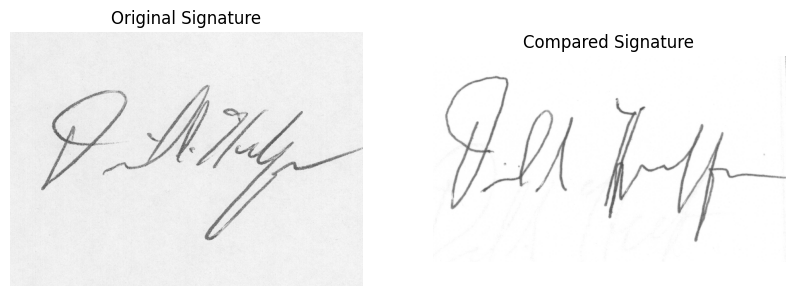

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
The signature comparison result is: Forged
Similarity score: 7.758189706982832e-13


In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the size of the input images
size = 128  # Example size, adjust based on your dataset

# Load the trained model
model = tf.keras.models.load_model("/kaggle/input/model/keras/default/1/siamese_signature_model.keras")

# Function to preprocess a single image (resize and normalize)
def preprocess_single_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)  # Add channel dimension

# Function to verify if two signatures match
def verify_signature(signature1_path, signature2_path):
    # Preprocess both images
    img1 = preprocess_single_image(signature1_path)
    img2 = preprocess_single_image(signature2_path)
    
    # Display images using matplotlib
    original = cv2.imread(signature1_path)
    forged = cv2.imread(signature2_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Signature")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(forged, cmap='gray')
    plt.title("Compared Signature")
    plt.axis('off')
    
    plt.show()
    
    # Make prediction using the Siamese network
    prediction = model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])
    
    # If the output is closer to 1, it is a genuine match, otherwise, it is a forged signature
    result = "Genuine" if prediction > 0.8 else "Forged"
    print(f"The signature comparison result is: {result}")
    print(f"Similarity score: {prediction[0][0]}")

# Paths to the test signature images
signature1_path = "/kaggle/input/cedardataset/signatures/full_org/original_10_1.png"
signature2_path = "/kaggle/input/cedardataset/signatures/full_forg/forgeries_10_1.png"

# Run the signature verification
verify_signature(signature1_path, signature2_path)


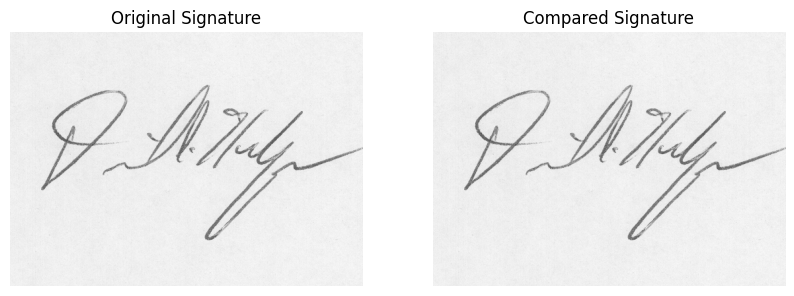

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
The signature comparison result is: Genuine
Similarity score: 0.9999996423721313


In [5]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the size of the input images
size = 128  # Example size, adjust based on your dataset

# Load the trained model
model = tf.keras.models.load_model("/kaggle/input/model/keras/default/1/siamese_signature_model.keras")

# Function to preprocess a single image (resize and normalize)
def preprocess_single_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)  # Add channel dimension

# Function to verify if two signatures match
def verify_signature(signature1_path, signature2_path):
    # Preprocess both images
    img1 = preprocess_single_image(signature1_path)
    img2 = preprocess_single_image(signature2_path)
    
    # Display images using matplotlib
    original = cv2.imread(signature1_path)
    forged = cv2.imread(signature2_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Signature")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(forged, cmap='gray')
    plt.title("Compared Signature")
    plt.axis('off')
    
    plt.show()
    
    # Make prediction using the Siamese network
    prediction = model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])
    
    # If the output is closer to 1, it is a genuine match, otherwise, it is a forged signature
    result = "Genuine" if prediction > 0.8 else "Forged"
    print(f"The signature comparison result is: {result}")
    print(f"Similarity score: {prediction[0][0]}")

# Paths to the test signature images
signature1_path = "/kaggle/input/cedardataset/signatures/full_org/original_10_1.png"
signature2_path = "/kaggle/input/cedardataset/signatures/full_org/original_10_1.png"

# Run the signature verification
verify_signature(signature1_path, signature2_path)
